# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("ResNet50_Freeze")
mlflow.set_tag("mlflow.runName", "version 2")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated')

2025/06/17 15:32:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        image_tensor = transform(img_pil)

        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [7]:
print(len(data))

178


In [8]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [9]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [10]:
# Stratified K Folde Cross Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Function to Load Pre-trained Model from Pytorch

In [11]:
def create_model():
    model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    num_classes = 4 # Change output to 4 for desired classification task
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    for param in model.parameters():
         param.requires_grad = False
    # Unfreeze the last layer
    for param in model.fc.parameters():
         param.requires_grad = True
    return model

# Grid Search Parameters

In [12]:
# Grid Search Parameters
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'train_batch_size': [16, 32, 64],
    'test_batch_size': [16],
    'weight_decay': [0.0, 1e-4],
}

In [13]:
# Use itertools.product to iterate through combinations
from itertools import product

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Model training

In [14]:
def train(model, optimizer, dataloader, criterion, device):
    model.train()
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [15]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [16]:
categories = []
accuracies = []
results = []
num_epochs = 40
for params in param_combinations:
    config = dict(zip(param_names, params))
    print(f"Testing params: {config}")
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"Fold {fold+1}")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=config['train_batch_size'], shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=config['test_batch_size'])

        model = create_model()  # Initialize fresh model per fold
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        criterion = torch.nn.CrossEntropyLoss()
        model.to(DEVICE)

        # Train and evaluate
        for epoch in range(num_epochs):  # or another stopping criterion
            train(model, optimizer, train_loader, criterion, DEVICE)

        acc = evaluate(model, val_loader, DEVICE)
        fold_accuracies.append(acc)

    avg_acc = np.mean(fold_accuracies)
    print(f"Average Accuracy: {avg_acc:.4f}")
    results.append((config, avg_acc))

Testing params: {'lr': 0.01, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8933
Testing params: {'lr': 0.01, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8989
Testing params: {'lr': 0.01, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8933
Testing params: {'lr': 0.01, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8767
Testing params: {'lr': 0.01, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8600
Testing params: {'lr': 0.01, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8989
Testing params: {'lr': 0.001, 'train_batch_size':

# Visualize

In [24]:
print(type(results[0]))

<class 'tuple'>


TypeError: unhashable type: 'numpy.ndarray'

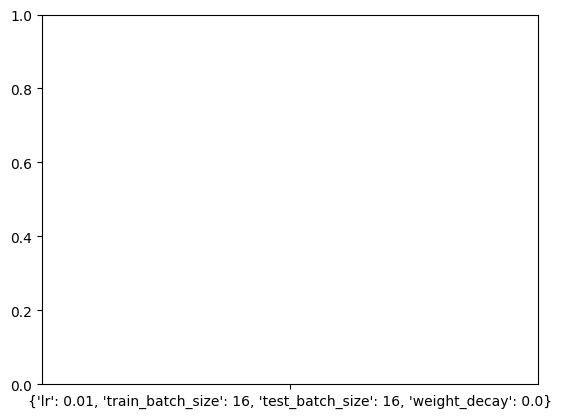

In [17]:
plt.bar(categories, results, width = 0.5)
plt.legend()
plt.title("Accuracy Per Grid Search")
plt.show()

# Load MlFlow Registerd Model

In [ ]:
model_name = "ResNet50_Freeze"
model_version = "1"
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}")

# Test Model with Seperated Test Data

In [ ]:
def predict(model, image_path):
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil).unsqueeze(0).to(DEVICE) #Already transformed into a tensor here

    model.eval()
    with torch.no_grad():
        predictions_log = model(image_tensor)
        predictions_prob = torch.exp(predictions_log)
        max_probability_predicted, max_probability_index = torch.max(predictions_prob, dim=1)
    return max_probability_index.item()

In [ ]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
predicted, ground_truth = [], []
for style in os.listdir(TEST_FOLDER_DIR):
    correct_result = CLASSIFICATION_MAPPING[style]
    style_path = os.path.join(TEST_FOLDER_DIR, style)
    for pic in os.listdir(style_path):
        predicted_result = predict(model, os.path.join(style_path, pic))
        predicted.append(predicted_result)
        ground_truth.append(correct_result)

In [ ]:
predicted = torch.tensor(predicted)
ground_truth = torch.tensor(ground_truth)

accuracy = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
precision = Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
recall = Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
f1score = F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

In [ ]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())